# Fine-tuning a Pre-Trained LM

Based on the paper ["Perspective changes in human listeners are aligned with
the contextual transformation of the word embedding
space"](https://academic.oup.com/cercor/article-abstract/33/12/7830/7080913?redirectedFrom=fulltext), in this tutorial you will fine-tune two versions of BERT using custom medical and space [news datasets](https://huggingface.co/datasets/newsgroup) to perform a binary classification task, and then compare the two models' performance and embeddings spaces.

You will use relatively close domains for fine-tuning both models to show that even when learning from semantically similar texts their embedding space will change in measurably diferent ways.

To do so you will need to:
1. Load pre-trained BERT model and tokenizer
2. Preprocess the dataset for training
3. Freeze the early layers of the model
4. Fine-tune both versions of the model (MedBert and SpaceBERT) on their respective train sets
5. Calculate each models' accuracy on it's own dataset as well as the other's test set to check how specialized their learning was
6. Extract embeddings from the 2 models for various words and see how similar/different they are

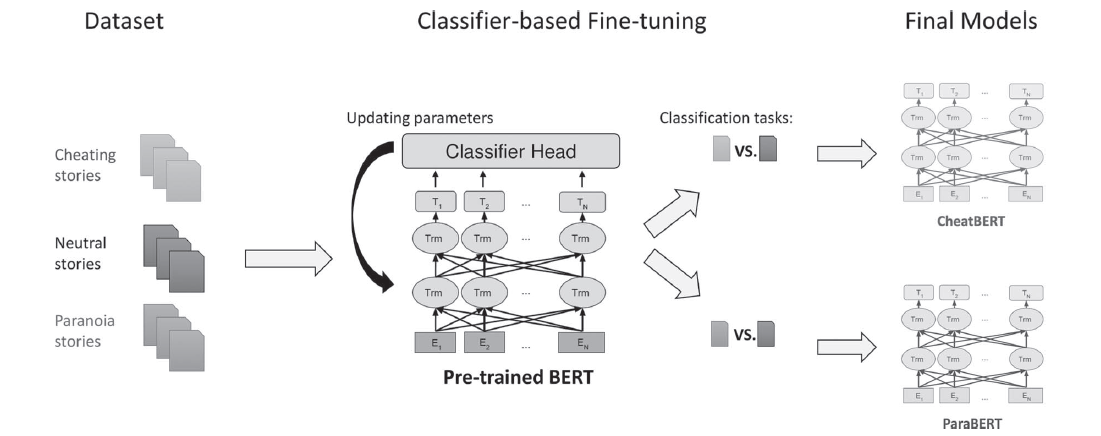

Setting up the enivornment (feel free to install more packages if needed)

In [1]:
! pip install -U accelerate
! pip install -U transformers
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:00:00


To fine-tune BERT to perform binary classification you will need to load a pretrained version of the model using the from_pretrained function of [AutoModelForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSequenceClassification)  and [AutoTokenizer](https://https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) classes from the Transformers library.

When calling ` AutoModelForSequenceClassification.from_pretrained()`  along side the model name "bert-base-uncased" pass **num_labels=2**.
and "name" your labels (0 - negative, 1 - positive) using the id2label and label2id variables like they do here:
https://huggingface.co/docs/transformers/tasks/sequence_classification

Make sure to load the model twice into two differnet objects - one for SpaceBERT and one for MedBERT, but you can use the same tokenizer for both.

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

pretrained_model_name = "bert-base-uncased"
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

SpaceBERT = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2, id2label=id2label, label2id=label2id)
MedBERT =  AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2, id2label=id2label, label2id=label2id)

models = [SpaceBERT, MedBERT]
model_names = ["SpaceBERT", "MedBERT"]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To create our custom datasets (one for each version of BERT) we need both positive and negative examples.

We will use the [newwsgroup](https://huggingface.co/datasets/newsgroup
) dataset which cotains multiple subsets and the [datasets](https://https://huggingface.co/docs/datasets) library.

For both versions we will use the subsets **19997_sci.crypt**  + **19997_sci.electronics** as the negative examples.

For MedBERT we will use the **19997_sci.med** subset as positive examples, where the goal is to teach it to distinguish medical scientific texts from other displicines.

For MedBERT we will use the **19997_sci.space** subset as positive examples, with a similar goal.

Load the dataset with the datasets function named (surpise, surpise) `load_dataset`.

**Note**: This dataset has only "train" examples (technicality) so after loading make sure to take the "train" part like so:

```
crypt_dataset = load_dataset("newsgroup", "19997_sci.crypt")
crypt_dataset = crypt_dataset["train"]
```

Make sure to add a **"label"** column to each part of your dataset with the appropriate value (0 - negative, 1 positive)


So for the negative examples do the following:
1. load  19997_sci.crypt and 19997_sci.electronics subsets (separately)
2. for each one take only train part
3. combine them using [concatenate_datasets](https://https://huggingface.co/docs/datasets/v2.16.1/en/package_reference/main_classes#datasets.concatenate_datasets) function
4. add column with name "label" to the combined dataset with value 0

In [3]:
from datasets import load_dataset, ClassLabel, concatenate_datasets

crypt_dataset = load_dataset("newsgroup", "19997_sci.crypt")
crypt_dataset = crypt_dataset["train"]
electronics_dataset = load_dataset("newsgroup", "19997_sci.electronics")
electronics_dataset = electronics_dataset["train"]
negative_label_dataset = concatenate_datasets([crypt_dataset, electronics_dataset]).shuffle(seed=42)
negative_label_dataset = negative_label_dataset.add_column(name="label", column=[0]*len(negative_label_dataset))

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/2000 [00:00<?, ? examples/s]

The same way load the subsets containing the positive examples for each version of BERT, add "label" column with value 1, and combine it with the negative examples.

**Reminder**: You should have 2 datasets - one for each version of BERT.

After combining negative and positive examples into one dataset cast the label column to [ClassLabel](https://huggingface.co/docs/datasets/about_dataset_features) type like so:

```
label_names = ClassLabel(num_classes = 2, names=["neg", "pos"])
my_dataset = my_dataset.cast_column("label", label_names)
```

In [4]:
#SPACE DATASET
space_dataset_dict = load_dataset("newsgroup", "19997_sci.space")
space_dataset = space_dataset_dict["train"]
space_dataset = space_dataset.add_column(name="label", column=[1]*len(space_dataset))

space_dataset = concatenate_datasets([space_dataset, negative_label_dataset]).shuffle(seed=42)
is_space = ClassLabel(num_classes = 2, names=["neg", "pos"])
space_dataset = space_dataset.cast_column("label", is_space)

#MEDICAL DATASET
med_dataset_dict = load_dataset("newsgroup", "19997_sci.med")
med_dataset = med_dataset_dict["train"]
med_dataset = med_dataset.add_column(name="label", column=[1]*len(med_dataset))

med_dataset = concatenate_datasets([med_dataset, negative_label_dataset]).shuffle(seed=42)
is_med = ClassLabel(num_classes = 2, names=["neg", "pos"])
med_dataset = med_dataset.cast_column("label", is_med)

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3000 [00:00<?, ? examples/s]



Finally, remember to split each of your 2 datasets into train and test (70% train, 30% test) using the [train_test_split](https://huggingface.co/docs/datasets/v2.16.1/en/package_reference/main_classes#datasets.Dataset.train_test_split) function.

In [5]:
final_space_dataset = space_dataset.train_test_split(test_size=0.3, seed=42)

final_med_dataset = med_dataset.train_test_split(test_size=0.3, seed=42)

Don't forget to tokenize your datasets before passing it to the model for training using the map function, with batched=True flag.

See example here: https://huggingface.co/docs/transformers/training

(There is no need to do padding at this stage, instead use the DataCollatorWithPadding class when training.)

In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_space_dataset = final_space_dataset.map(tokenize_function, batched=True)
tokenized_med_dataset = final_med_dataset.map(tokenize_function, batched=True)

tokenized_datasets = [tokenized_space_dataset, tokenized_med_dataset]


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

To stay consistent with the paper (and to make the training much faster) we will freeze all of BERT's layers besides the last 3 (out of 12),
by setting `requires_grad = False` for all the params in those layers.

**Note**: This code assumes you have a list variable named `models` which containts the two pre-trained versions of BERT you loaded.
If this is true, you can run it as is.

In [7]:
for model in models:
  modules = [model.bert.embeddings, model.bert.encoder.layer[:9]]
  for module in modules:
      for param in module.parameters():
          param.requires_grad = False

Use the HuggingFace [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric to calculate your model's (you guessed it) accuracy, wrap it in a method and pass it to the model Trainer object using the **compute_metrics** variable.

Rememer, the model's predictions will allways be *logits* and your labels are *binary* so you'll need to handle that before calling the accuracy.compute() function that will actually compare the predictions and labels.

You can see example of how to do that here (note that they use a different metric):
https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt

In [8]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

It's time to train (fine-tune)!

To do so you will need to do the following (for each version of BERT):
1. Init DataCollatorWithPadding object with you tokenizer
2. Init TrainingArguments object with these arguments to make training run faster: `evaluation_strategy="epoch", save_strategy="no"`
3. Init Trainer object and pass to it the DataCollatorWithPadding and TrainingArguments objects you created, as well as your (pre-trained) model, tokenizer and dataset.
4. run trainer.train()

If you're running on T4 machine, training should take ~5-7 min for each model.

You can calculate the model's accuracy before and after training to see how well it's learned (on it's test set).

Make sure to save your Trainer objects for the next part.

In [9]:
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainers = []

for model, model_name, tokenized_dataset in zip(models, model_names, tokenized_datasets):
  training_args = TrainingArguments(output_dir=model_name,
                                    overwrite_output_dir=True,
                                    evaluation_strategy="epoch",
                                    save_strategy="no")

  trainer = Trainer(model=model,
                    args=training_args,
                    train_dataset=tokenized_dataset["train"],
                    eval_dataset=tokenized_dataset["test"],
                    tokenizer=tokenizer,
                    data_collator=data_collator,
                    compute_metrics=compute_metrics)

  eval_results_before_training = trainer.evaluate()
  print(f"Accuracy before training: {round(eval_results_before_training['eval_accuracy'], 3)}")

  trainer.train()

  eval_results_after_training = trainer.evaluate()
  print(f"Accuracy after training: {round(eval_results_after_training['eval_accuracy'], 3)}")

  trainers.append(trainer)


Accuracy before training: 0.527


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.000114,1.000000
2,0.032200,0.000054,1.000000
3,0.032200,0.000043,1.000000


Accuracy after training: 1.0


Accuracy before training: 0.35


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.000088,1.000000
2,0.037400,0.000036,1.000000
3,0.037400,0.000029,1.000000


Accuracy after training: 1.0


To check how specialized each of your fine-tuned BERTs are, evaluate the performance of each one on the test set for the other's task (i.e evaluate SpaceBERT on the MedBERT's test set and vice versa).

To do so just call each trainer's in-build `evaluate` function on the corresponding test dataset.

In [10]:
SpaceBERT_on_med_test_acc = trainers[0].evaluate(eval_dataset=tokenized_med_dataset["test"])
print(f"SpaceBERT's accuracy on medical test set: {round(SpaceBERT_on_med_test_acc['eval_accuracy'], 3)}")

MedBERT_on_space_test_acc = trainers[1].evaluate(eval_dataset=tokenized_space_dataset["test"])
print(f"MedBERT's accuracy on space test set: {round(MedBERT_on_space_test_acc['eval_accuracy'], 3)}")

SpaceBERT's accuracy on medical test set: 0.671


MedBERT's accuracy on space test set: 0.66


Usually when we talk about the embedding learned by a Language Model for a given word we mean the **last** hidden state representation (meaning the state of the last layer of the model before the final output - logits in the case of an AutoRegressiveModel or the class in our case).

You can also experiment with using earlier hidden states for the embeddings if you like.

To extract the embedding of a word you will need to do the following:
1. Encode the word using the tokenizer + convert it to a torch.tensor + apply `unsqueeze(0).to(device='cuda')` to the tensor
2. Pass the resulting tensor to the model along with the flag `output_hidden_states=True`.
For more details read the [documentation](
https://huggingface.co/docs/transformers/v4.34.0/en/main_classes/output#transformers.modeling_outputs.SequenceClassifierOutput ).
3. Extract `output['hidden_states'][-1]` (output is the output of the model) + apply `squeeze(0).cpu()` to the result

**IMPORTANT NOTE**:
BERT's tokenizer will encode any word (i.e 'dog') as at least 3 tokens, adding two special tokens: a [CLS] token before the word, and a [SEP] token after (i.e [CLS] dog [SEP]).

So when extracting the embedding for the word, make sure to access the result of `output['hidden_states'][-1]` at the right index (in the example above the index for 'dog' is 1).



In [11]:
import torch

words = ["dog", "the", "planet", "nurse", "scope"]

SpaceBERT_emeddings = []
MedBERT_emeddings = []

with torch.no_grad():
  for word in words:
    input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0).to(device='cuda')

    SpaceBERT_outputs = SpaceBERT(input_ids, output_hidden_states=True)
    SpaceBERT_emeddings.append(SpaceBERT_outputs['hidden_states'][-1].squeeze()[1].cpu())

    MedBERT_outputs = MedBERT(input_ids, output_hidden_states=True)
    MedBERT_emeddings.append(MedBERT_outputs['hidden_states'][-1].squeeze()[1].cpu())

To see if and how your fine-tuning affected the embeddings space of the original model, measure how similar SpaceBERT and MedBERT's embeddings are for different words (related to medicine/space as well as "everyday" words) using [cocine-similarity score](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html) .

When passing the embeddings of the models to cosine_similarity function perform unsqueeze(0) on each one.

In [12]:
from torch.nn.functional import cosine_similarity

cosine_sims = []
for i, word in enumerate(words):
  cosine_sims.append(cosine_similarity(SpaceBERT_emeddings[i].unsqueeze(0), MedBERT_emeddings[i].unsqueeze(0)))


print(f"The word with most similar embeddings between the two models is: {words[np.argmax(cosine_sims)]}\n")
print(f"The word with most different embeddings between the two models is: {words[np.argmin(cosine_sims)]}\n")

The word with most similar embeddings between the two models is: the

The word with most different embeddings between the two models is: scope



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Which words have the most similar embeddings between the two models? Which ones are the most differnt? Does this surprise you?